# ECE387 Project 2: Manipulator Control Based on Computer Vision
### A note on this document
This document is known as a Jupyter notebook; it is used in academia and industry to allow text and executable code to coexist in a very easy to read format. Blocks can contain text or code, and for blocks containing code, press `Shift + Enter` to run the code. Earlier blocks of code need to be run for the later blocks of code to work.

### Objectives
The purpose of this project is to control the robotic arm using computer vision.

<img src="figs/AprilTagBlocks.jpg" alt="Blocks" style="width: 500px;"/>

In this project, you will  
- Use OpenMV camera to detect, identify, and localize multiple AprilTags.
- Write a Python script to search for blocks and find the locations of the blocks using the AprilTags attached on them.
- Write a Python script for the robotic arm to move the blocks.

### AprilTags

AprilTag is a visual fiducial system, useful for a wide variety of tasks including augmented reality, robotics, and camera calibration. We will learn how fiducial markers are used in image processing. Specifically, we will utilize MicroPython to identify different AprilTags and use the 3D position and orientation to determine the distance of an object from the camera.

<img src="figs/AprilTags.png" alt="AprilTags" style="width: 500px;"/>

A fiducial marker is an artificial feature used in creating controllable experiments, ground truthing, and in simplifying the development of systems where perception is not the central objective. A few examples of fiducial markers include ArUco Markers, AprilTags, and QR codes. Each of these different tags hold information such as an ID or, in the case of QR codes, websites, messages, and etc. We will primarily be focusing on AprilTags as there is a very robust Python package already built. This library identifies AprilTags and will provide information about the tags size, distance, and orientation.

ref: https://april.eecs.umich.edu/software/apriltag


### OpenMV Cam

Go to https://openmv.io/pages/download to download the latest OpenMV IDE.  Install the software on your computer.

- Connect the camera to your computer and run the software. 
- Download `find_apriltags_3d_pose_4.py` from Teams.
- In OpenMV IDE, go to File > Open File and select `find_apriltags_3d_pose_4.py` to load.
- Click the Connect button on the bottom left of the IDE.  
- Click the Start button (green arrow).
- Click the `Serial Terminal` tab at the bottom of the window.
- Bring in blocks under the camera to detect them.

<img src="figs/DetectingBlock.png" alt="Blocks" style="width: 350px;"/>

On Serial Terminal, you will find numbers similar to

`2,3,4.041906,-1.517668,-9.712036,181.984062,358.371687,224.128056,4,5.561428,1.540591,-9.330090,160.538206,354.057860,201.279116`

The descriptions of the data fields are as follows.
- Field 1: Number of AprilTags detected.
- Field 2: AprilTag ID
- Field 3: x value
- Field 4: y value
- Field 5: z value
- Field 6: Rx value
- Field 7: Ry value
- Field 8: Rz value
- Field 9: AprilTag ID
- Field 10: x value
- Field 11: y value
- Field 12: z value
- Field 13: Rx value
- Field 14: Ry value
- Field 15: Rz value
-    :
-    :

The values are based on large-sized AprilTags. So, the distances returned by the program must be scaled. For example, $z = -9.712$ m is incorrect, and it shoud probably be 11 cm. So, we need to find the scale factor and offset.  

### Least Sqaures Regression

We need to solve a least squares regression problem to find a linear equation that best fits the measured data. 
Let the measured data is given by 

$$ y = [-10, 4, 7, 21]$$

and the corresponding values are given by

$$ x = [0, 1, 2, 3]$$

The goal is to find $m$ and $c$ such that 

$$ y = mx + c $$ best approximates the linear relationship between $x$ and $y$.

Let's first plot the data

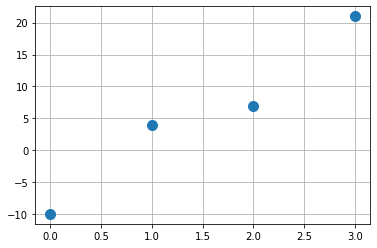

In [2]:
import numpy as np
import matplotlib.pyplot as plt

x = np.array([0, 1, 2, 3])
y = np.array([-10, 4, 7, 21])

plt.plot(x, y, 'o', markersize=10)
plt.grid('on')
plt.show()

It is evdient that $x$ and $y$ are not linearly related, but we still want to find an equation of line that best fits the data.

We can rewrite the line equation as y = Ab, where

$A = \begin{bmatrix} x & 1\end{bmatrix} $ and $\mathbf{b} = \begin{bmatrix} m \\ c\end{bmatrix} $. 

That is,

$y = mx + c = \begin{bmatrix} x & 1\end{bmatrix} \begin{bmatrix} m \\ c\end{bmatrix} = A\mathbf{b}$ 


With the $x$ and $y$ values, we can obtain

$\begin{bmatrix} -10 \\ 4 \\ 7 \\ 21\end{bmatrix} = \begin{bmatrix} 0 & 1 \\ 1 & 1 \\2 & 1 \\3 & 1 \end{bmatrix} \begin{bmatrix} m \\ c\end{bmatrix}$ 


Now use `lstsq` to solve for $\mathbf{b}$:

In [3]:
A = np.vstack([x, np.ones(len(x))]).T
print(A)

[[0. 1.]
 [1. 1.]
 [2. 1.]
 [3. 1.]]


In [4]:
m, c = np.linalg.lstsq(A, y, rcond=None)[0]
print(m, c)

9.599999999999996 -8.899999999999993


Therefore, the best fitting line is
$$ y = 9.6x-8.9$$

Let's plot the line along with the data

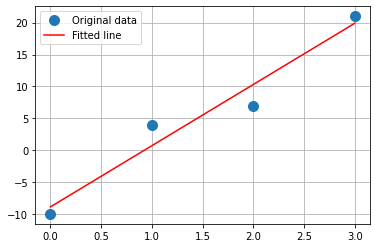

In [5]:
plt.plot(x, y, 'o', label='Original data', markersize=10)
plt.plot(x, m*x + c, 'r', label='Fitted line')
plt.legend()
plt.grid('on')
plt.show()

Our goal is to find the line that best approximates the data.

Place the camera at the orign and a block with an AprilTag at $(x,y)$ = (10, 0) cm. Place the block on top of another block for 1 inch above the ground. 

As you move the block 1 cm in the $x$ direction at a time, record the $z$ values returned by the apriltag detection in OpenMV IDE.  Although it is the $x$ direction on the grid, it is actually the $z$ direction of the camera.

In [ ]:
y = np.arange(0.1, 0.28, 0.01)  # 10 cm - 28 cm incremented by 1 cm
# add your measurements here
x = np.array([])
A = np.vstack([x, np.ones(len(x))]).T
m, c = np.linalg.lstsq(A, y, rcond=None)[0]
print(m, c)
plt.plot(x, y, 'o', label='Measured data', markersize=10)
plt.plot(x, m*x + c, 'r', label='Fitted line')
plt.legend()
plt.grid('on')
plt.show()

Repeat the same for the $x$ direction (horizontal direction) of the camera - It is the $y$ direction of the grid. You can ignore the offset this time, because the pixel at the center of the image is always $(x, y)$ = (0,0).  The offset you observe while taking measurements are due to the misalignment of the camera's $x-y$ plane and the grid's $x-y$ plane.  

You don't have to repeat it for camera's $y$ direction (vertical direction). We can use the same fitting values for the $x$ direction. They should be them same theoretically.

### Update OpenMV MicroPython

Since we are not going to use the orientation of AprilTags, we don't have to send it to the PC.  Update your MicroPython code as follows

```
tag_output = list()
num_tags = 0

# add the following lines and provide the values
# mz is the slope for the z direction
# cz is the offset for the z direction
# mx is the slope for the x direction
# my is the slope for the y direction, and it should be the same as mx
mz =
cz =
mx =
my =  


while(True):
    clock.tick()
    :
    :
    for tag in tags:
        img.draw_rectangle(tag.rect(), color = (255, 0, 0))
        img.draw_cross(tag.cx(), tag.cy(), color = (0, 255, 0))
        # update the below line
        print_args =  (tag.id(), tag.x_translation()*mx, tag.y_translation()*my, tag.z_translation()*mz + cz)
        # Translation units are unknown. Rotation units are in degrees.
        # upldate the below line
        print(",%d,%f,%f,%f" % print_args, end='')
```




Save the code to OpenMV cam as shown below

<img src="figs/OpenMV_SaveToCam.png" alt="Blocks" style="width: 350px;"/>


### Search for Blocks

We need to search for blocks with AprilTags using the OpenMV cammera attached to the robotic arm. Add the following code to the constructor (`def --init__(...)`) into your `xArm.py`

In [ ]:
        self.B0 = 0.090
        self.L1 = 0.010
        self.L2 = 0.105
        self.L3 = 0.088
        self.L4 = 0.170
        #self.camera_distance = 0.133 # distance of OpenMV cam from Joint5
        self.camera_dist_offset = 0.037  # L4 - camera_distance
        
                
        
        # ADD this for OpenMV Cam
        self.mvcam = None
        self.curr_joint_angles = None
        
        # dictionary for block locations
        # for short tutorial for Python dictionary, visit https://www.w3schools.com/python/python_dictionaries.asp
        self.block_locations = dict()


Add the following `Tag` class before `class XArm(rbt.DHRobot):`

In [ ]:
class Tag(NamedTuple):
    """ Data structure for AprilTag
    """
    id: int
    x: float
    y: float
    z: float
        
        
class XArm(rbt.DHRobot):

Add the following two functions into your xArm.py.

In [ ]:
    def connect_mvcam(self):

        if isinstance(self.mvcam, serial.Serial):
            print(f"The robot is already connected to {self.comm.port}")
            return

        ports = list_ports.comports()
        comport = None

        for port, desc, hwid in sorted(ports):
            if 'OpenMV Cam' in desc:
                comport = port
                print("Info: OpenMV Cam is connected to")
                print("{}: {} [{}]".format(port, desc, hwid))
                break

        if comport is None:
            print("Error: Serial port for OpenMV is not available.")
            print("OpenMV Cam is not connected.")
            return

        # A serial port is found.  Try to connect.
        try:
            self.mvcam = serial.Serial(
                port=comport,
                baudrate=115200,
                parity=serial.PARITY_NONE,
                stopbits=serial.STOPBITS_ONE,
                bytesize=serial.EIGHTBITS,
                timeout=0.01
            )
            print(f"Info: OpenMV is connected to {comport}")

        except serial.SerialException:
            print("Error: Serial port is not available.")
            print("OpenMV is not connected.")
            
            
    def search_for_blocks(self, duration_ms, pose, steps):
        """ Search for blocks with AprilTags.
        The robotic arm will be moved from the current pose to pose (argument) for duration_ms.
        During the transition from the current pose to the desired pose, the robot will stop moving to search
        for blocks. The number of stops during the transition is given by the steps argument.
        Once it finds a block, it will calculate the pose of the block wrt Frame 0 using the
        current joint angles and the position of the block wrt to the camera frame. Then, it will update
        self.block_locations with the pose of the block wrt Frame 0.
        If a block is detected multiple times, self.block_locations will be updated with the latest location.
        :param duration_ms: time in milliseconds to travel from the current
        position to the desired position.
        :param pose: 1x5 array of the pose of the tooltip.
        The first three elements are the position of the tooltip in meters,
        and the last two elements are the wrist angles in radians.
        :param steps: the number of stops during the transition
        :return: None

        Example:
        robot = XArm(simulation_only=False)
        robot.connect_mvcam()
        robot.connect()

        duration_ms = 2000
        steps = 20

        robot.move_to_initial_pose(duration_ms)
        pose = (0.12, -0.15, 0.12, -pi/4, 0)
        robot.search_for_blocks(duration_ms, pose, steps)
        """
        
        joint_angles = self.invkine(pose)

        if joint_angles is None:
            print("No solution to inverse kinematics for ", pose)
            return

        angle_step = (joint_angles[0, :] - self.curr_joint_angles)/steps
        dtime_ms = duration_ms//steps

        for i in range(steps):
            self.curr_joint_angles += angle_step
            self.move_joints(dtime_ms, self.curr_joint_angles, wait=True)

            # print(np.rad2deg(self.curr_joint_angles))
            data = self.mvcam.readline().decode('ascii').strip().split(',')

            if len(data) < 2:
                continue

            num_tags = int(data.pop(0))
            tags = list()
            for i in range(num_tags):
                tagid = int(data[4*i])
                x, y, z = map(float, data[4*i+1:4+4*i])

                """ Write your code to find the location of the block wrt the 
                inertial reference frame, Frame {0}
                """
                # Find the transformation matrix of Tool Frame wrt Frame 0
                # Hint: You need only one line of code here
                
                
                # Find the transformation matrix of the block wrt Frame 0
                # Hint: you need only one line of code (Look at Lab1)
                
                
                # Add the location (translation, or the x-,y-,z-coordinates) of the block.
                self.block_locations[tagid] = 0  # replace 0 with the location of the block.  
                
            # comment out the following line if you don't want to print    
            [print(key, ', ', self.block_locations[key]) for key in self.block_locations.keys()]



Complete the `search_for_blocks` function. Use the following code to test the function.

In [ ]:
def test_search_for_blocks():

    # Set simulation_only=True to test the OpenMV cam.
    # Set it False to test the camera while the robot is moving.    
    robot = XArm(simulation_only=True)
    robot.connect_mvcam()
    robot.connect()

    duration_ms = 2000
    steps = 0  # pick a number for steps.

    robot.move_to_initial_pose(duration_ms)
    
    pose = (0, 0, 0, 0, 0)  # pick the start pose for searching 
    robot.moveto(duration_ms, pose, wait=True)

    pose = (0, 0, 0, 0, 0)  # pick the destination pose for searching
    robot.search_for_blocks(duration_ms, pose, steps)
    
    pose = (0, 0, 0, 0, 0) # pick the next destination pose for searching
    robot.search_for_blocks(duration_ms, pose, steps)


### Deliverable 1 (10 points)

Your code should be able to find and identify blocks placed at,
- (22, 0, 0)
- (30, 0, 0)
- (19, -10, 0)
- (26, -11, 0)
- (25, 18, 0)

**Report the console output printed by the following code inside `search_for_blocks`.**

`[print(key, ', ', self.block_locations[key]) for key in self.block_locations.keys()]`





### Deliverable 2 (40 points)
As you can find, the localization accuracy is sometimes very poor depending highly on where the block is located in the image frame. If the block is at the center of the image frame, it is usually pretty accurate. If the block is located at the corner or side of the image frame, it has a large error. How would you improve the accuracy? 

A few ideas that you may want to consider (not necessarily good ideas)
- Average out all the measurements
- Based on the locations you initially have, move the arm where a block can be located at the center of the image frame, and retake a measurement.

**Report the following in your final report**
- Implementation of your idea in xArm.py.  You can modify the `search_for_blocks` method or create your own method.
- Justification of the idea.
- Measurements.
- Analysis of your data.

In the real engineering world, there are always multiple solutions available. There is no right or wrong solution, but there are better solutions. I would like to see your ideas, implementation, justification, and analysis. 

### Deliverable 3 (30+ points)

**Demo (30 pts):** Search for a block with AprilTag ID 0 (let's call it Block 0) and Block 1, and place Block 0 on top of Block 1.

The blocks are placed anywhere near the five locations ($\pm 5$ cm) in Deliverable 1. 

**Demo (3 - 7 bonus pts):** Move multiple blocks (Blocks 0 - 3) on top of Block 4.
- 2 blocks: + 3 points
- 3 blocks: + 5 points
- 3 blocks: + 7 points


### Deliverable 4 (20 points)

**Submit final report.**

Your report should include the following sections or similar:

- Objective
- Methods
- Results and Analyses
- Conclusion 

There are no requirements for font size, page margins, number of pages, etc. Write a professional, senior-level report. 
Do not use _you_ in your report.  
Hint: I love figures and tables as long as they are legible.
